In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

sns.set_theme(style="whitegrid")

Shape: (103904, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location      

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,103904.0,51951.500000,29994.645522,0.0,25975.75,51951.5,77927.25,103903.0
id,103904.0,64924.210502,37463.812252,1.0,32533.75,64856.5,97368.25,129880.0
Age,103904.0,39.379706,15.114964,7.0,27.00,40.0,51.00,85.0
Flight Distance,103904.0,1189.448375,997.147281,31.0,414.00,843.0,1743.00,4983.0
Inflight wifi service,103904.0,2.729683,1.327829,0.0,2.00,3.0,4.00,5.0
Departure/Arrival time convenient,103904.0,3.060296,1.525075,0.0,2.00,3.0,4.00,5.0
Ease of Online booking,103904.0,2.756901,1.398929,0.0,2.00,3.0,4.00,5.0
Gate location,103904.0,2.976883,1.277621,0.0,2.00,3.0,4.00,5.0
Food and drink,103904.0,3.202129,1.329533,0.0,2.00,3.0,4.00,5.0
Online boarding,103904.0,3.250375,1.349509,0.0,2.00,3.0,4.00,5.0


Gender distribution:
 Gender
Female    52727
Male      51177
Name: count, dtype: int64 

Customer Type distribution:
 Customer Type
Loyal Customer       84923
disloyal Customer    18981
Name: count, dtype: int64 

Type of Travel distribution:
 Type of Travel
Business travel    71655
Personal Travel    32249
Name: count, dtype: int64 

Class distribution:
 Class
Business    49665
Eco         46745
Eco Plus     7494
Name: count, dtype: int64 

satisfaction distribution:
 satisfaction
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64 



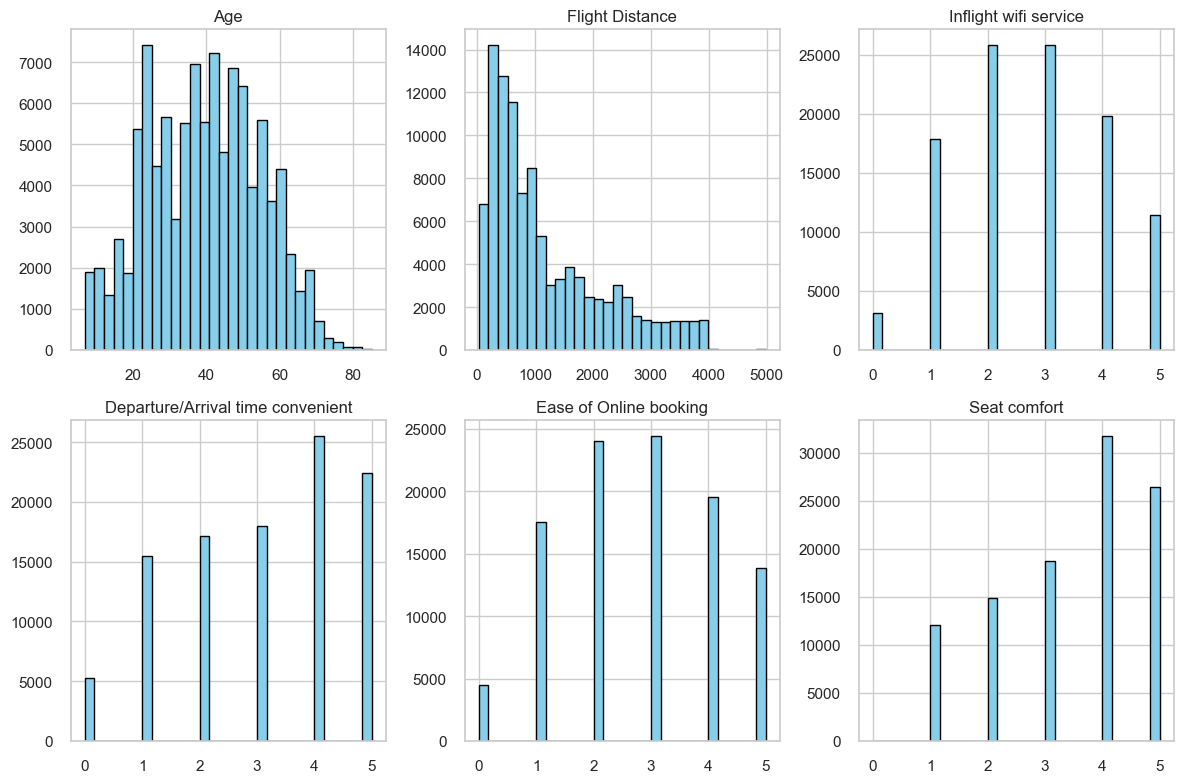

In [2]:
data = pd.read_csv("train.csv")

# Основная информация о датасете
print("Shape:", data.shape)
print(data.info())
print("Missing values:\n", data.isnull().sum())
display(data.describe().T)

# Проверка распределения категориальных признаков
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']
for col in cat_cols:
    print(f"{col} distribution:\n", data[col].value_counts(), "\n")

# Проверка распределения числовых признаков
num_cols = ["Age", "Flight Distance", "Inflight wifi service",
            "Departure/Arrival time convenient", "Ease of Online booking", "Seat comfort"]
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(data[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
plt.tight_layout()
plt.show()

In [3]:
# Удаляем строки с некорректными/нулевыми значениями
data = data[data['Inflight wifi service'] != 0]
data = data[data['Class'] != 'Eco Plus']  # Исключаем Eco Plus по заданию

# Преобразуем категориальные признаки в числовые
mapping = {
    'Gender': {'Female': 0, 'Male': 1},
    'Customer Type': {'Loyal Customer': 0, 'disloyal Customer': 1},
    'Type of Travel': {'Business travel': 0, 'Personal Travel': 1},
    'Class': {'Business': 0, 'Eco': 1},
    'satisfaction': {'neutral or dissatisfied': 0, 'satisfied': 1}
}
data = data.replace(mapping)

# Удаляем лишние столбцы
data = data.drop(columns=['id', 'Unnamed: 0', 'Arrival Delay in Minutes'])

# Сохраняем целевую переменную (если будет использоваться для внешней оценки)
satisfaction = data['satisfaction'].copy()
data = data.drop(columns=['satisfaction'])

C:\Users\vfvjx\AppData\Local\Temp\ipykernel_12556\555576555.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(mapping)


In [4]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

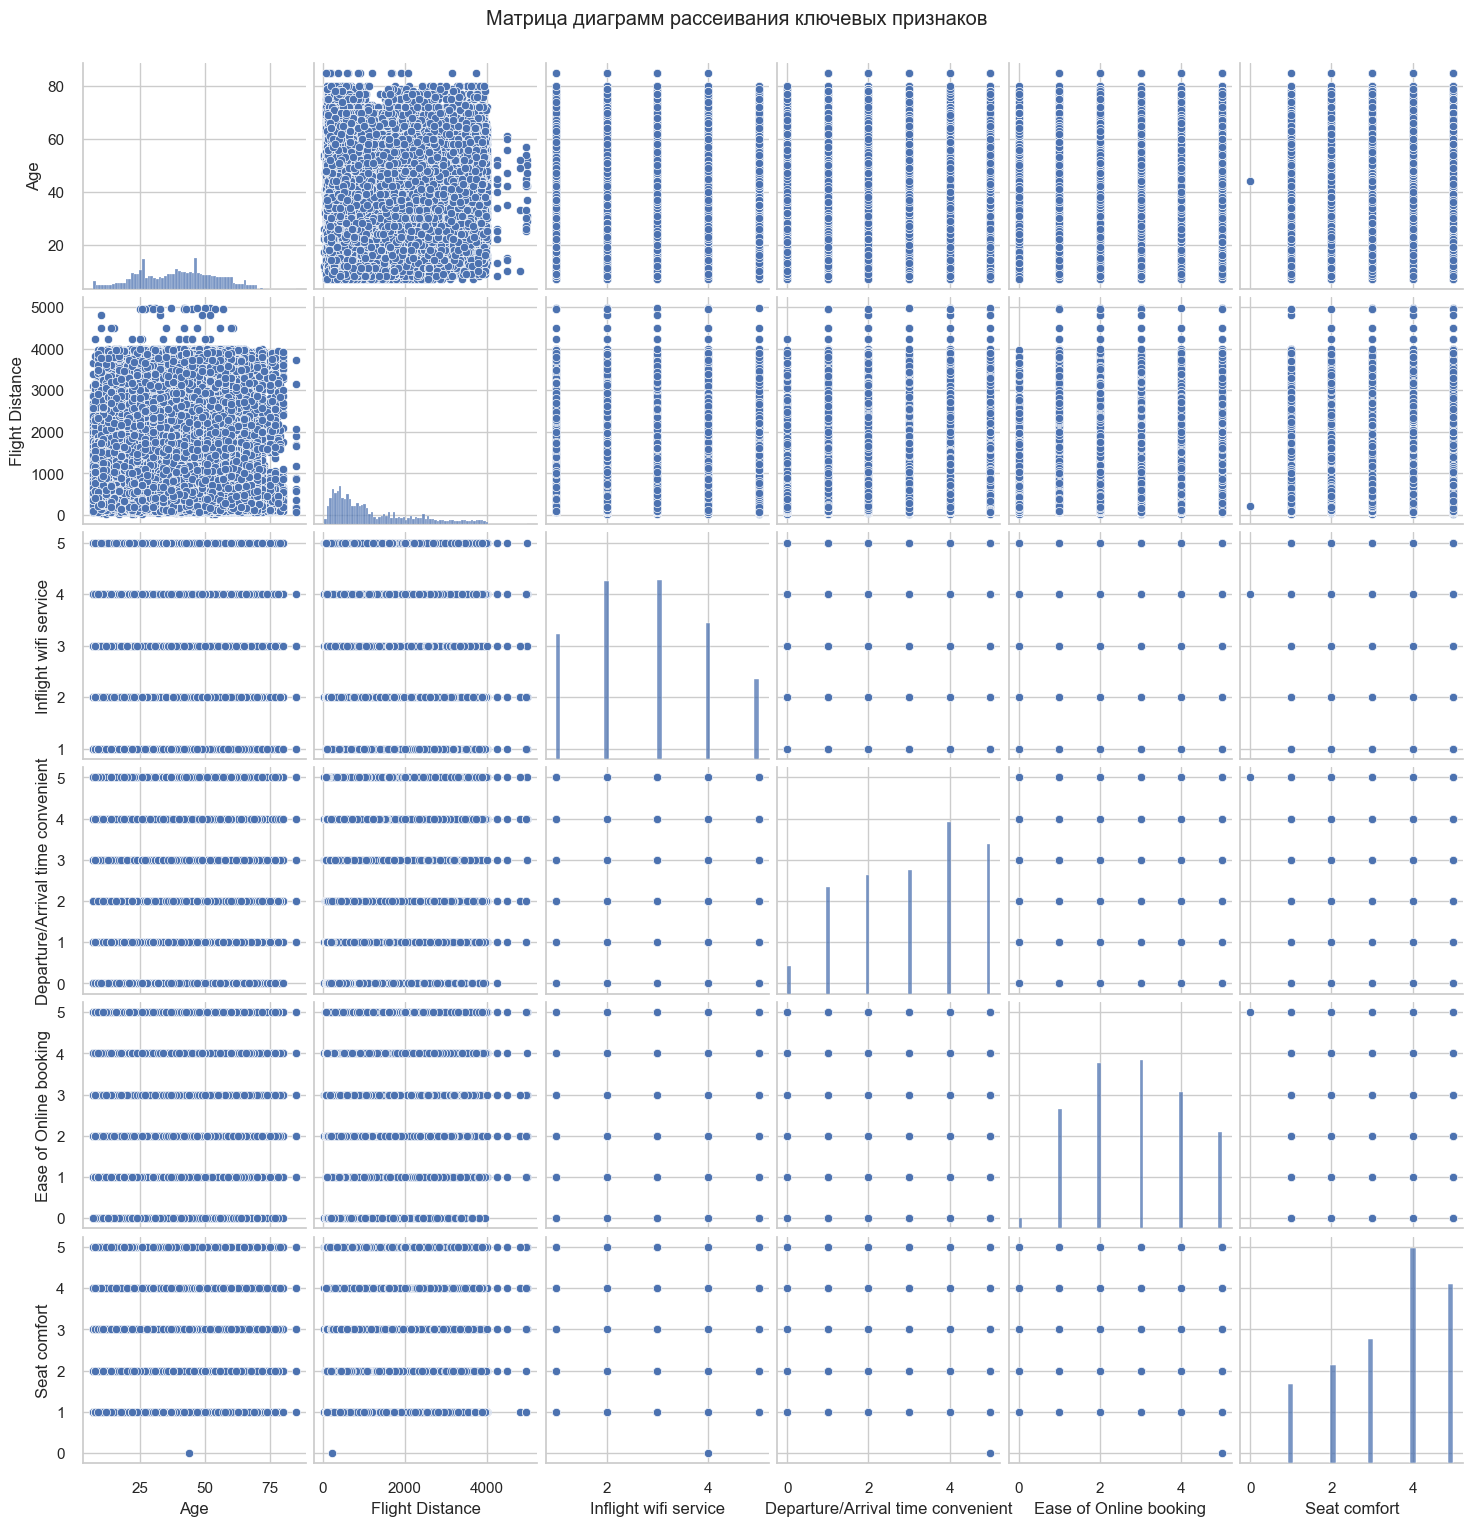

In [5]:
# PCA для снижения размерности для визуализации
pca = PCA(n_components=3, random_state=42)
data_pca = pd.DataFrame(pca.fit_transform(data_scaled), columns=['PC1', 'PC2', 'PC3'])

# Матрица диаграмм рассеивания ключевых признаков
key_features = ["Age", "Flight Distance", "Inflight wifi service",
                "Departure/Arrival time convenient", "Ease of Online booking", "Seat comfort"]
sns.pairplot(data[key_features])
plt.suptitle("Матрица диаграмм рассеивания ключевых признаков", y=1.02)
plt.show()

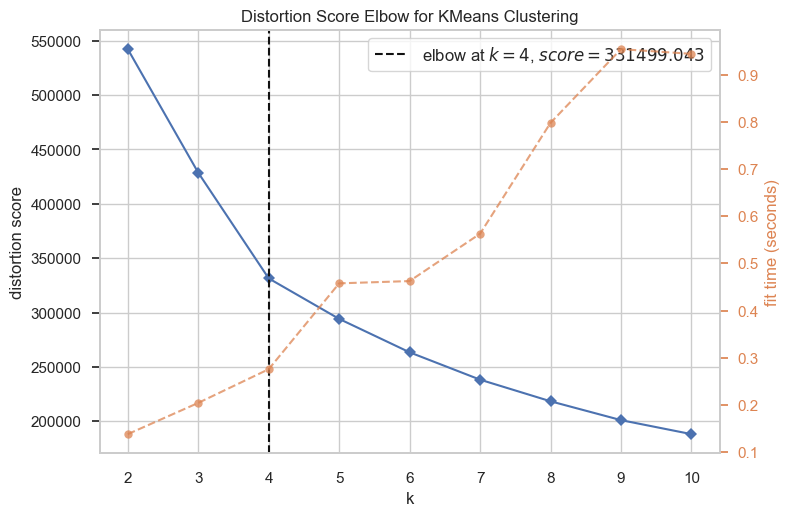

Optimal k: 4


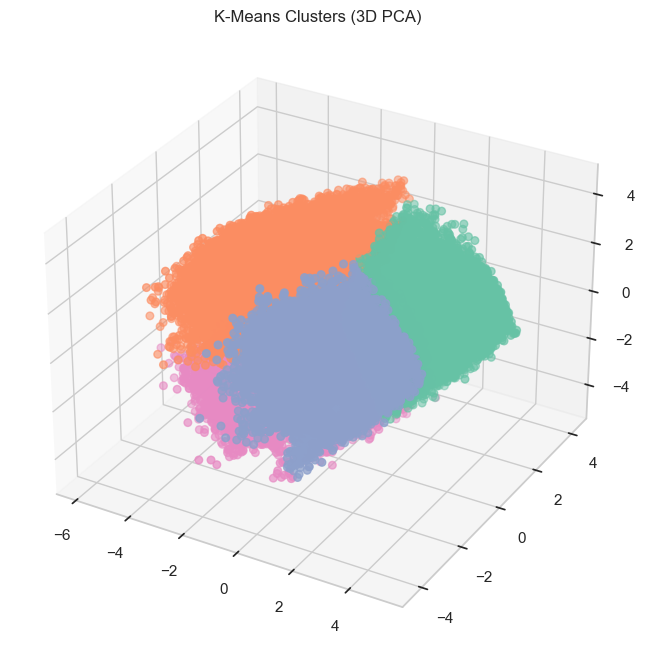

Silhouette Score: 0.105, Calinski-Harabasz Score: 10345.783


KMeansCluster,0,1,2,3
Gender,0.497695,0.544018,0.494462,0.440888
Customer Type,0.107986,0.334432,0.160722,0.151943
Age,42.119962,32.801953,40.811613,42.092518
Type of Travel,0.153528,0.464858,0.193755,0.383424
Class,0.242328,0.757238,0.301000,0.650127
Flight Distance,1541.972856,849.923883,1443.324909,1063.349873
Inflight wifi service,4.016192,2.428511,1.945499,2.654300
Departure/Arrival time convenient,4.010125,3.096023,2.025518,2.976881
Ease of Online booking,3.994169,2.579054,1.814930,2.783374
Gate location,3.834141,2.971768,1.925104,2.993073


In [7]:
# Определяем оптимальное число кластеров методом локтя
elbow = KElbowVisualizer(KMeans(n_init=10, random_state=42), k=10)
elbow.fit(data_pca)
elbow.show()
optimal_k = elbow.elbow_value_
print("Optimal k:", optimal_k)

# Строим модель K-Means
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(data_pca)
data_pca['KMeansCluster'] = kmeans_labels
data['KMeansCluster'] = kmeans_labels

# Визуализация кластеров
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
cmap = colors.ListedColormap(sns.color_palette("Set2", optimal_k))
ax.scatter(data_pca['PC1'], data_pca['PC2'], data_pca['PC3'], c=data_pca['KMeansCluster'], cmap=cmap, s=30)
ax.set_title("K-Means Clusters (3D PCA)")
plt.show()

# Метрики качества
sil_score = silhouette_score(data_scaled, kmeans_labels)
ch_score = calinski_harabasz_score(data_scaled, kmeans_labels)
print(f"Silhouette Score: {sil_score:.3f}, Calinski-Harabasz Score: {ch_score:.3f}")

# Профили кластеров
cluster_profiles = data.groupby('KMeansCluster').mean().T
display(cluster_profiles.style.background_gradient(cmap='RdYlGn', axis=1))

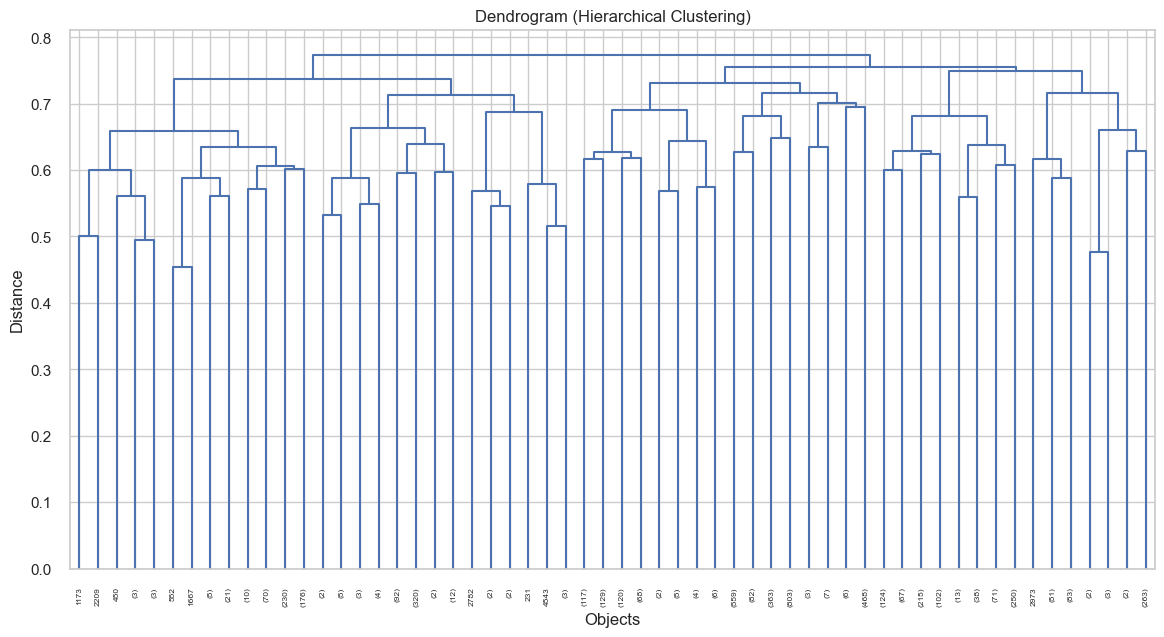

HierCluster
2    2742
1     973
3     880
4     405
Name: count, dtype: int64


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,KMeansCluster
HierCluster,,,,,,,,,,,,,,,,,,,,,
1,1,0,24,0,1,399,2,4,3,3,...,2,2,3,4,4,3,4,2,0,1
2,0,0,39,0,0,373,4,4,3,3,...,4,4,4,4,4,4,4,4,0,0
3,1,0,27,0,1,337,3,4,3,3,...,3,3,3,3,3,3,3,3,0,3
4,0,0,49,0,0,2586,2,4,4,3,...,4,2,2,2,2,3,2,4,0,3


In [8]:
# Для ускорения выборка
sample = data.sample(5000, random_state=42)

# Вычисление матрицы расстояний (Hamming для категориальных признаков)
dist_matrix = pdist(sample, metric='hamming')

# Строим дендрограмму
Z = linkage(dist_matrix, method='average')
plt.figure(figsize=(14, 7))
dendrogram(Z, truncate_mode='level', p=5, color_threshold=0.2)
plt.title("Dendrogram (Hierarchical Clustering)")
plt.xlabel("Objects")
plt.ylabel("Distance")
plt.show()

# Формируем кластеры
k_hier = 4
hier_labels = fcluster(Z, k_hier, criterion='maxclust')
sample['HierCluster'] = hier_labels
print(sample['HierCluster'].value_counts())

# Профили кластеров
cluster_profiles_hier = sample.groupby('HierCluster').agg(lambda x: x.value_counts().index[0])
display(cluster_profiles_hier)

In [10]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import squareform

# Преобразуем матрицу расстояний в квадратную форму
dist_square = squareform(dist_matrix)

# Silhouette Score (используем precomputed)
sil_score = silhouette_score(dist_square, hier_labels, metric='precomputed')

# Calinski-Harabasz и Davies-Bouldin требуют числовых признаков, поэтому используем sample без категориальных преобразований
# В нашем случае можно стандартизировать числовые признаки
num_cols = sample.select_dtypes(include=np.number).columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sample_scaled = scaler.fit_transform(sample[num_cols])

ch_score = calinski_harabasz_score(sample_scaled, hier_labels)
db_score = davies_bouldin_score(sample_scaled, hier_labels)

print(f"Hierarchical Clustering Metrics:")
print(f"Silhouette Score (Hamming distance): {sil_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")


Hierarchical Clustering Metrics:
Silhouette Score (Hamming distance): 0.104
Calinski-Harabasz Score: 451.871
Davies-Bouldin Score: 2.880


In [9]:
print("K-Means vs Hierarchical cluster sizes:")
print(data['KMeansCluster'].value_counts())
print(sample['HierCluster'].value_counts())

K-Means vs Hierarchical cluster sizes:
KMeansCluster
0    25383
3    23963
1    23661
2    20495
Name: count, dtype: int64
HierCluster
2    2742
1     973
3     880
4     405
Name: count, dtype: int64
